In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install -q datasets transformers
!pip install transformers
!pip install accelerate>=0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


# Import necessary libraries

In [71]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
import json
import matplotlib.pyplot as plt
from PIL import Image


# Set the Static values



In [6]:
model_checkpoint = "microsoft/resnet-50" # pre-trained model
batch_size = 32 # batch size we will use in our program

# Input dataset of images


In [13]:
dataset = load_dataset("imagefolder", data_files="/content/data_x (1).zip" )


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Load the Accuracy metric, which we'll use to evaluate our model

In [14]:
metric = load_metric("accuracy")

# Test dataset

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2201
    })
})

In [16]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['COVID', 'Normal'], id=None)}

In [17]:
ex = dataset["train"][10]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=299x299>,
 'label': 0}

<PIL.PngImagePlugin.PngImageFile image mode=L size=299x299 at 0x7A14A6516620>
0


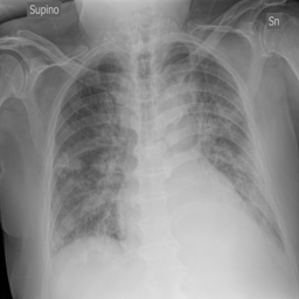

In [18]:
print(ex['image'])
print(ex['label'])
dataset["train"][1]['image']

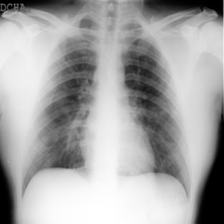

In [19]:
ex['image'].resize((224, 224))

In [20]:
dataset["train"].features["label"]

ClassLabel(names=['COVID', 'Normal'], id=None)

# Set labels by thier numerical values

In [21]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'COVID': 0, 'Normal': 1}
{0: 'COVID', 1: 'Normal'}


# **Process** **images** by using Auto Image Processor


In [22]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [23]:


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)


if "height" in image_processor.size:


    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [24]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [25]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=299x299>,
 'label': 1,
 'pixel_values': tensor([[[ 0.3138,  0.3138,  0.3138,  ...,  0.8618,  1.1358,  1.3413],
          [ 0.3138,  0.2967,  0.2796,  ...,  0.8961,  1.1358,  1.3242],
          [ 0.3138,  0.2796,  0.2282,  ...,  0.9303,  1.1358,  1.2899],
          ...,
          [-0.0458, -0.0287,  0.0056,  ...,  0.7933,  0.7248,  0.6563],
          [-0.0801, -0.0458,  0.0227,  ...,  0.9303,  0.8447,  0.7762],
          [-0.0972, -0.0458,  0.0398,  ...,  1.0159,  0.9303,  0.8618]],
 
         [[ 0.4503,  0.4503,  0.4503,  ...,  1.0105,  1.2906,  1.5007],
          [ 0.4503,  0.4328,  0.4153,  ...,  1.0455,  1.2906,  1.4832],
          [ 0.4503,  0.4153,  0.3627,  ...,  1.0805,  1.2906,  1.4482],
          ...,
          [ 0.0826,  0.1001,  0.1352,  ...,  0.9405,  0.8704,  0.8004],
          [ 0.0476,  0.0826,  0.1527,  ...,  1.0805,  0.9930,  0.9230],
          [ 0.0301,  0.0826,  0.1702,  ...,  1.1681,  1.0805,  1.0105]],
 


# Train model


In [26]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you'd like to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/103M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-covid-normal",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [40]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [41]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [42]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [43]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.677500,0.666454,0.647059
2,0.606900,0.597254,0.733032
4,0.552900,0.561824,0.809955


In [49]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.5618236064910889, 'eval_accuracy': 0.8099547511312217, 'eval_runtime': 34.9979, 'eval_samples_per_second': 6.315, 'eval_steps_per_second': 0.2, 'epoch': 4.84}


In [54]:
trainer.save_model()
trainer.log_metrics("train", results.metrics)
trainer.save_metrics("train", results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        4.84
  total_flos               = 189542869GF
  train_loss               =      0.6052
  train_runtime            =  1:16:42.14
  train_samples_per_second =       2.151
  train_steps_per_second   =       0.016


In [55]:
metrics['eval_loss']

0.5618236064910889

# Visualisation


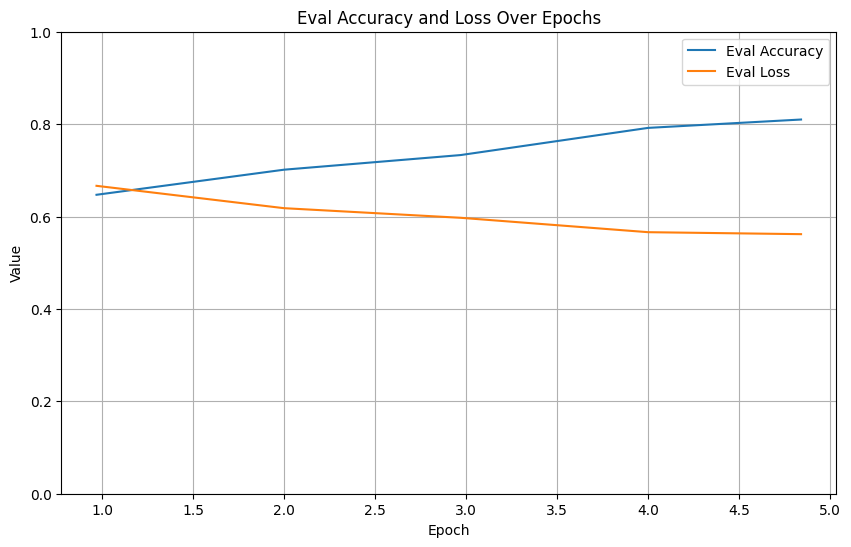

In [79]:

json_file_path = '/content/resnet-50-covid-normal/trainer_state.json'

with open(json_file_path, 'r') as file:
    data = json.load(file)

# Extract relevant information
epochs = [entry["epoch"] for entry in data["log_history"]]
eval_accuracy = [entry.get("eval_accuracy", None) for entry in data["log_history"]]
eval_loss = [entry.get("eval_loss", None) for entry in data["log_history"]]

# Filter out entries with None values
valid_indices = [i for i, acc in enumerate(eval_accuracy) if acc is not None]
epochs = [epochs[i] for i in valid_indices]
eval_accuracy = [eval_accuracy[i] for i in valid_indices]
eval_loss = [eval_loss[i] for i in valid_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_accuracy, label='Eval Accuracy')
plt.plot(epochs, eval_loss, label='Eval Loss')

plt.title('Eval Accuracy and Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 1])  # Set Y-axis limit to 0-1 for accuracy
plt.legend()
plt.grid(True)
plt.show()

In [80]:
from transformers import pipeline

pipe = pipeline("image-classification", r"/content/resnet-50-covid-normal",feature_extractor=image_processor)
pipe

In [77]:
import os

folder_path = "/content/testing data"

# List all files in the folder
files = os.listdir(folder_path)

# Filter only image files (you can adjust the extensions as needed)
image_files = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]

# Create an empty list to store opened images
opened_images = []

# Loop through each image file and open it
for image_file in image_files:
    # Create the full path to the image
    image_path = os.path.join(folder_path, image_file)
    # Open the image
    image = Image.open(image_path).convert('RGB')

    # Append the opened image to the list
    opened_images.append(image)

In [86]:
import glob


test = pipe(glob.glob('/content/testing data/COVID-1.png'))
df = pd.DataFrame(test)
df

,0,1
0,"{'score': 0.5737215876579285, 'label': 'COVID'}","{'score': 0.4262784421443939, 'label': 'Normal'}"


In [91]:
image_files = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]
for images in image_files:
  print(images)
  test = pipe(glob.glob('/content/testing data/'+images))
  df = pd.DataFrame(test)
  print( df)

COVID-3.png
                                                 0  \
0  {'score': 0.5245433449745178, 'label': 'COVID'}   

                                                   1  
0  {'score': 0.47545671463012695, 'label': 'Normal'}  
Normal-3.png
                                                  0  \
0  {'score': 0.5033739805221558, 'label': 'Normal'}   

                                                  1  
0  {'score': 0.49662598967552185, 'label': 'COVID'}  
Normal-2.png
                                                0  \
0  {'score': 0.57323157787323, 'label': 'Normal'}   

                                                  1  
0  {'score': 0.42676839232444763, 'label': 'COVID'}  
Normal-1.png
                                                 0  \
0  {'score': 0.573242723941803, 'label': 'Normal'}   

                                                  1  
0  {'score': 0.42675721645355225, 'label': 'COVID'}  
COVID-2.png
                                                  0  \
0  {'score':

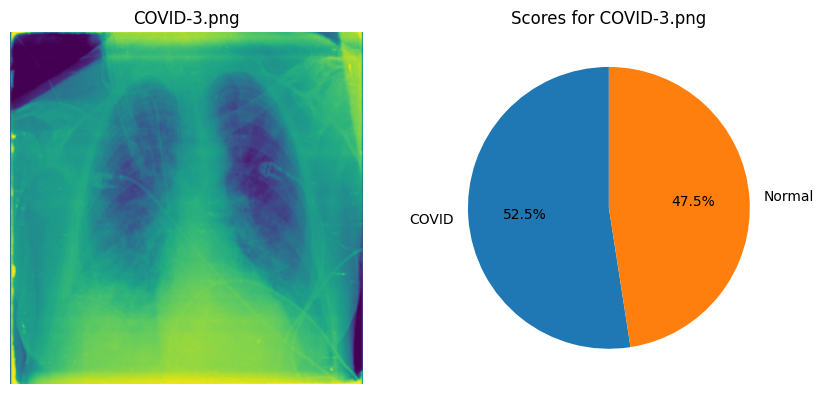

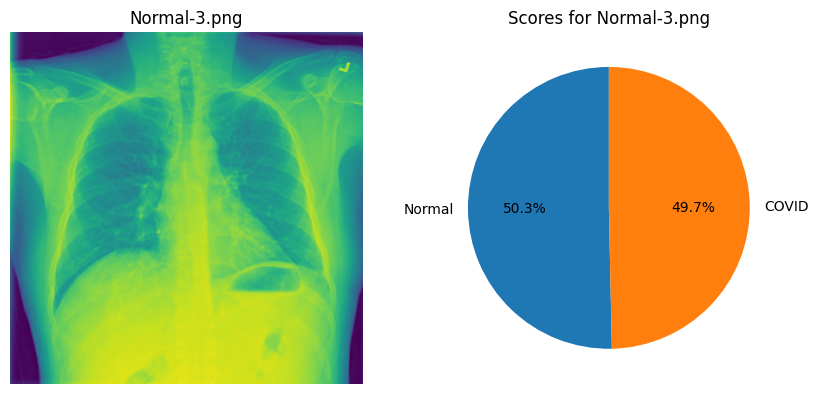

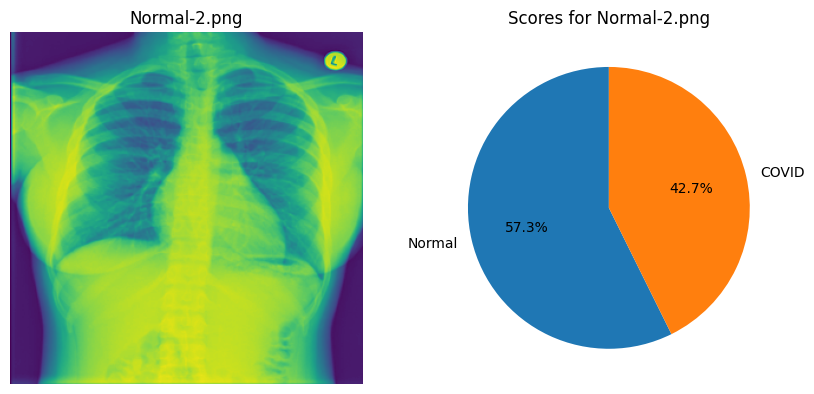

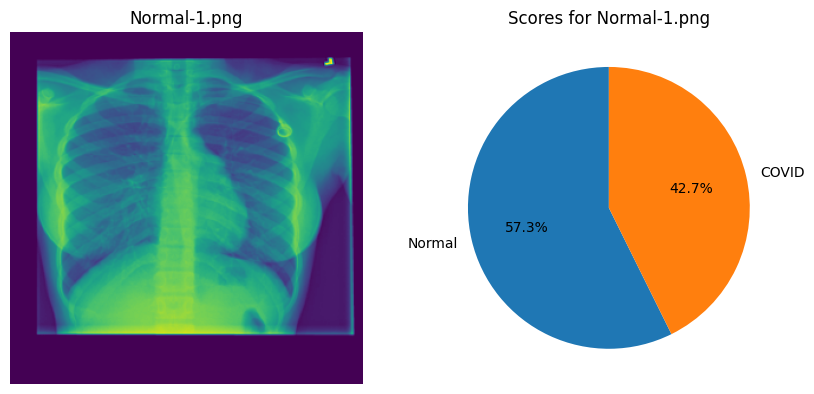

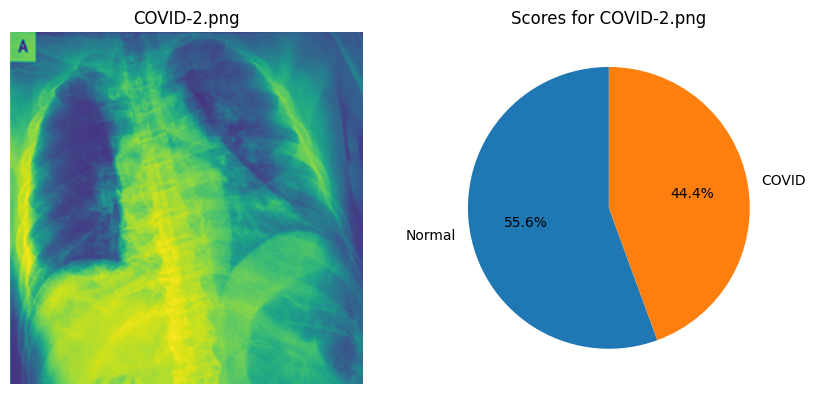

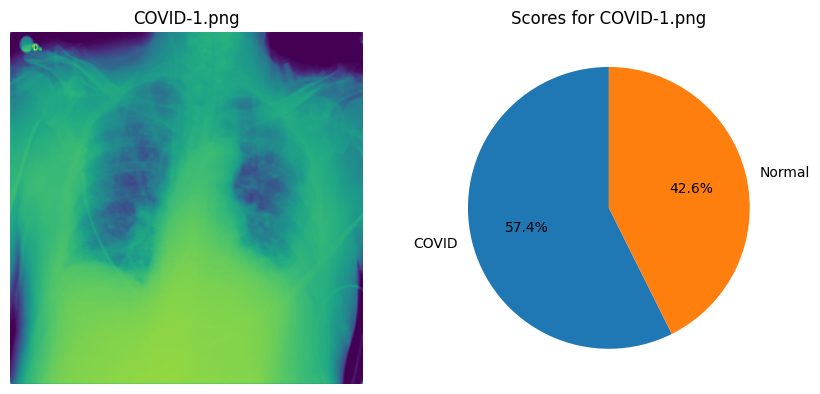

In [104]:
for images in image_files:
  test = pipe(glob.glob('/content/testing data/'+images))
  df = pd.DataFrame(test)
  for index, row in df.iterrows():
      # Display the image
      ig, axes = plt.subplots(1, 2, figsize=(10, 5))
      img_path = f"/content/testing data/{images}"  # Replace with the correct path
      img = plt.imread(img_path)
      axes[0].imshow(img)
      axes[0].axis('off')
      axes[0].set_title(images)

      # Display the pie chart
      scores = [entry['score'] for entry in row]
      labels = [entry['label'] for entry in row]
      axes[1].pie(scores, labels=labels, autopct='%1.1f%%', startangle=90)
      axes[1].set_title(f'Scores for {images}')

      plt.show()